## Introducción a pre-trained models, transfer learning and fine tuning

```
Última actualización 04/08/2025
```



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jeffersonrodriguezc/deep-learning-en-3-semanas/blob/main/semana_3/notebooks/Nb_3a_Introduccion_transfer_learning_finetuning.ipynb)

In [1]:
#@title Eliminar librerías (Problema de compatibilidad reciente con numpy )
from IPython.display import clear_output

!pip uninstall  -y numpy
!pip -q install numpy==1.26.4

clear_output()

In [ ]:
#@title Ejecutar esta celda para reiniciar el entorno de ejecución
import os
os.kill(os.getpid(), 9)

In [1]:
#@title Instalar librerías necesarias

!pip -q install keras-nlp
!pip -q install gensim
!pip -q install pytorch-tabnet
!pip install tabpfn
!pip install wget


import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import pandas as pd
import keras_hub
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import VGG16
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from gensim.models import KeyedVectors
from IPython.display import clear_output
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_covtype
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

from pytorch_tabnet.pretraining import TabNetPretrainer
from tabpfn import TabPFNClassifier
from sklearn.metrics import roc_auc_score

clear_output()

print("Se han importado todas las librerías correctamente")

Se han importado todas las librerías correctamente


In [2]:
#@title Definir funciones complementarias
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

def plot_curvas(history):
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plot_graphs(history, 'accuracy')
  plt.ylim(None, 1)
  plt.subplot(1, 2, 2)
  plot_graphs(history, 'loss')
  plt.ylim(0, None)

def cosine_similarity(vec_a, vec_b):
  """Compute cosine similarity between vec_a and vec_b"""
  return np.dot(vec_a, vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))

# dibujamos ciertos ejemplos de entrenamiento
def plot_imagenes(train_images,train_labels):
  plt.figure(figsize=(10, 4))
  for i in range(10):
      plt.subplot(2, 5, i + 1)
      plt.grid(False)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(train_images[i], cmap=plt.cm.gray)
      plt.xlabel(train_labels[i])
  plt.show()

def plot_predicciones(model,test_images):
  plt.figure(figsize=(10, 4))
  for i in range(10):
      plt.subplot(2, 5, i + 1)
      plt.grid(False)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(test_images[i], cmap=plt.cm.gray)
      pred = np.argmax(model.predict(np.expand_dims(test_images[i], axis=0), verbose=False))
      plt.xlabel(f"Pred: {pred}")
  plt.show()

def leer_datos_phishing():
    import zipfile
    import wget
    from scipy.io import arff


    # Dataset 1: Phishing Websites (.arff -> CSV manual en GitHub alternativo)
    url1 = "https://archive.ics.uci.edu/static/public/327/phishing+websites.zip"
    wget.download(url1)

    # Dataset 2: PhiUSIIL (CSV)
    url2 = "https://archive.ics.uci.edu/static/public/967/phiusiil+phishing+url+dataset.zip"
    wget.download(url2)

    with zipfile.ZipFile("phishing+websites.zip", 'r') as zip_ref:
        zip_ref.extractall("./phishing")

    data, meta = arff.loadarff('./phishing/Training Dataset.arff')
    # Convertir los datos a un DataFrame de Pandas
    df1 = pd.DataFrame(data)
    df1 = df1.astype(int)
    df1['Result'] = df1.Result.replace({-1:0})

    with zipfile.ZipFile("phiusiil+phishing+url+dataset.zip", 'r') as zip_ref:
        zip_ref.extractall("./phiusiil")

    df2 = pd.read_csv("./phiusiil/PhiUSIIL_Phishing_URL_Dataset.csv")

    return df1, df2

## Transfer Learning y fine tuning en Clasificación de imágenes

### Descargar los datos

In [ ]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print("Train shape: ", train_images.shape)
print("Test shape: ", test_images.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Train shape:  (60000, 28, 28)
Test shape:  (10000, 28, 28)


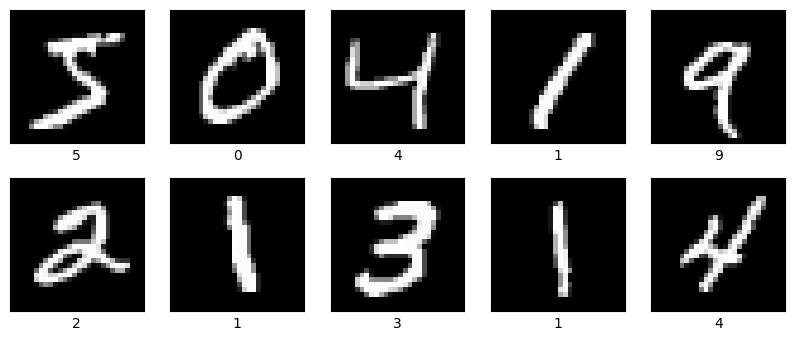

In [ ]:
plot_imagenes(train_images,train_labels)

In [ ]:
# Redimensionamos las imagenes a 32x32 (el minimo tamaño que soporta vgg16)
train_images = tf.image.grayscale_to_rgb(tf.expand_dims(train_images, axis=-1))
test_images = tf.image.grayscale_to_rgb(tf.expand_dims(test_images, axis=-1))
# Agregamos 3 canales de color (RGB) debido a que la red tambien lo necesita
train_images = tf.image.resize(train_images, [32, 32])
test_images = tf.image.resize(test_images, [32, 32])
# Normalizamos las imagenes entre [0, 1] para que el aprendizaje sea mas suave
train_images = train_images / 255.0
test_images = test_images / 255.0
print("Train shape: ", train_images.shape)
print("Test shape: ", test_images.shape)

Train shape:  (60000, 32, 32, 3)
Test shape:  (10000, 32, 32, 3)


In [ ]:
# Convertimos las etiquetas a formato one-hot encoding
train_labels_ohc = to_categorical(train_labels, 10)
test_labels_ohc = to_categorical(test_labels, 10)
print(train_labels_ohc[:,1])

[0. 0. 0. ... 0. 0. 0.]


### Transfer-learning

En esta sección, utilizaremos el modelo pre-entrenado [VGG16](https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16), el cual es una red convolucional que es usada para reconocimiento de imágenes. Este modelo fue entrenado con ImageNet, por lo cual es un modelo bastante robusto.

**Objetivo**:
- El objetivo será cargar dicho modelo pre-entrenado y utilizarlo sobre el dataset [MNIST](https://www.tensorflow.org/datasets/catalog/mnist), el cual contiene 70.000 imagenes de digitos escritos a mano. Así, poder clasificar dichos números con nuestro modelo entrenado previamente.

In [ ]:
# Cargamos el modelo VGG16 preentrenado, excluyendo las capas superiores (top=False)
# Recuerde que las capas superiores son las que definen el tipo de problema a solucionar
# Como nuestro problema es de 10 categorias (10 digitos), agregaremos nuestras propias capas superiores
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
vgg16_base.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Ahora congelamos los pesos del modelo, pues solo queremos agrega una nueva capa
# con 10 neuronas, donde cada una representará el digito que queremos predecir
vgg16_base.trainable = False
model = models.Sequential([
    vgg16_base,
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')  # 10 clases de salida
])

In [ ]:
# Compilamos y entrenamos los pesos de nuestra última capa
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_images, train_labels_ohc, epochs=5,
                    batch_size=64, validation_data=(test_images, test_labels_ohc))

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.5480 - loss: 1.4039 - val_accuracy: 0.8680 - val_loss: 0.5527
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8086 - loss: 0.6411 - val_accuracy: 0.8936 - val_loss: 0.4141
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8306 - loss: 0.5443 - val_accuracy: 0.9095 - val_loss: 0.3555
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8401 - loss: 0.5059 - val_accuracy: 0.9176 - val_loss: 0.3233
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8428 - loss: 0.4853 - val_accuracy: 0.9235 - val_loss: 0.3022


In [ ]:
# Medimos la precisión del modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_images, test_labels_ohc)

print(f"Precisión en el conjunto de prueba: {test_acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9145 - loss: 0.3246
Precisión en el conjunto de prueba: 0.9235000014305115


In [ ]:
# Mostramos el modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,730,080 (56.19 MB)

 Trainable params: 5,130 (20.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 10,262 (40.09 KB)

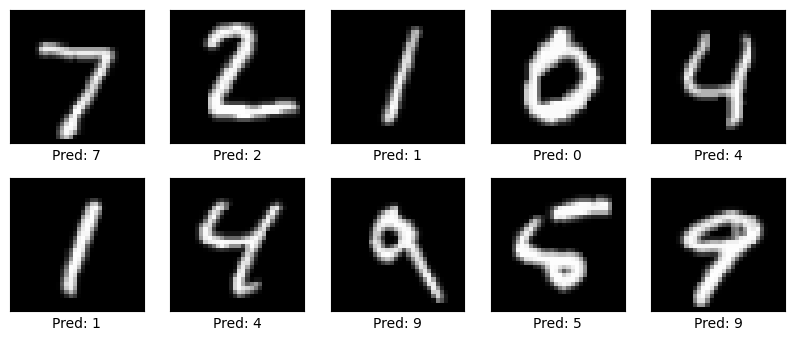

In [ ]:
# Dibujamos ciertas imágenes con sus predicciones
plot_predicciones(model,test_images)

**Observaciones:**

*   Note que al cargar un modelo pre-entrenado, logramos tener unos pesos que ya saben encontrar ciertos tipos de características dentro de las imágenes. Es por ello que cuando entrenamos nuestra capa superior (10 neuronas), solo hacen falta 5 épocas para alcanzar un accuracy del 92.14% en el conjunto de prueba.
* Cabe resaltar que utilizamos un modelo pre-entrenado y agregamos una capa superior para adaptarlo a nuestro problema. Esto se podría considerar *transfer learning* tambien.


### Tuning o Re-entrenamiento

Para dejar mas claro el concepto de *transfer learning* lo que haremos es coger el mismo modelo definido anteriormente, solo que esta vez si entrenaremos los pesos del modelo pre-entrenado, para así alcanzar un mejor rendimiento.

In [ ]:
# Reiniciar el backend para que las ejecuciones anteriores no interfieran
K.clear_session()

In [ ]:
# Definimos el modelo, especificando que queremos entrenar el modelo VGG16
vgg16_base.trainable = True
model_2 = models.Sequential([
    vgg16_base,
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')  # 10 clases de salida
])

In [ ]:
# Compilamos y entrenamos los pesos de nuestra última capa
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_2.fit(train_images, train_labels_ohc, epochs=5,
                    batch_size=64, validation_data=(test_images, test_labels_ohc))

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 31s 22ms/step - accuracy: 0.1100 - loss: 2.3122 - val_accuracy: 0.1135 - val_loss: 2.3011
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.1129 - loss: 2.3012 - val_accuracy: 0.1135 - val_loss: 2.3010
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.1132 - loss: 2.3009 - val_accuracy: 0.1135 - val_loss: 2.3011
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.1119 - loss: 2.3012 - val_accuracy: 0.1135 - val_loss: 2.3010
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.1119 - loss: 2.3014 - val_accuracy: 0.1135 - val_loss: 2.3011


In [ ]:
# Medimos la precisión del modelo 2 en el conjunto de prueba
test_loss, test_acc = model_2.evaluate(test_images, test_labels_ohc)

print(f"Precisión en el conjunto de prueba: {test_acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1160 - loss: 2.3010
Precisión en el conjunto de prueba: 0.11349999904632568


In [ ]:
# Imprimamos la estructura del modelo 2
model_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,159,456 (168.45 MB)

 Trainable params: 14,719,818 (56.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 29,439,638 (112.30 MB)

**Observaciones:**

*   Antes de hablar del mal rendimiento del modelo (un 9.7% de accuracy en el conjunto de prueba). Hay que hablar de que ahora demoró mas entrenandose. Esto se debe a que ahora, se ajustaron todos los parámeros posibles, no como en el modelo anterior que solo ajustamos los parámetros de la capa superior.

* Una de las razones por las cuales se obtuvo un *accuracy* muy bajo, es debido a que empezamos a ajustar el modelo pre-entrenado, pero pasamos de tener 512 neuronas como salida del modelo pre-entrenado, a solo tener 10. Entonces ese error se propagó y ajusto erróneamente los pesos ya entrenados. Lo cual llevó a que el modelo no mejorara.

* Para mitigar este error, utilizaremos *fine tunning* ajustando mas la capa superior. Así podremos tener un mejor rendimiento de nuestro modelo de *transfer learning*

### Fine tunning

- Para el ajuste fino, lo que haremos es lo siguiente:
  - Congelaremos las primeras capas del modelo pre-entrenado
  - Agregaremos unas capas superiores al modelo.
  - Entrenaremos el modelo así.
  - Después, descongelaremos capas superiores del modelo pre-entrenado y hacemos ese ajuste fino (entrenamos) para aumentar el acierto del modelo.

In [ ]:
# Reiniciar el backend para que las ejecuciones anteriores no interfieran
K.clear_session()

In [ ]:
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

for layer in vgg16_base.layers[:15]:  # Congelar las primeras 15 capas
    layer.trainable = False

# Agregamos mas neuronas después de nuestro modelo pre-entrenado, para hacer un ajuste mas fino
model_3 = models.Sequential([
    vgg16_base,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),  # Incrementamos el número de unidades para mayor capacidad de representación
    layers.Dropout(0.5),                   # Aumentamos el Dropout para evitar el sobreajuste
    layers.Dense(10, activation='softmax') # Capa final con 10 clases
])

In [ ]:
# compilamos el modelo y definimos una parada temprana para mitigar el sobreajuste
model_3.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# Entrenamos nuestro modelo
history = model_3.fit(train_images, train_labels_ohc, batch_size=64,
                      epochs=20,
                      validation_data=(test_images, test_labels_ohc),
                      callbacks=[early_stopping])

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.8968 - loss: 0.3208 - val_accuracy: 0.9841 - val_loss: 0.0493
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9850 - loss: 0.0495 - val_accuracy: 0.9894 - val_loss: 0.0372
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9884 - loss: 0.0397 - val_accuracy: 0.9913 - val_loss: 0.0275
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9912 - loss: 0.0292 - val_accuracy: 0.9925 - val_loss: 0.0288
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9929 - loss: 0.0242 - val_accuracy: 0.9854 - val_loss: 0.0503
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9937 - loss: 0.0216 - val_accuracy: 0.9908 - val_loss: 0.0320
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9937 - loss: 0.0199 - val_accuracy: 0.9897 - val_loss: 0.0335
Epoch 8/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9947 - loss: 0.0184 - val_accuracy: 

In [ ]:
# Evaluamos el accuracy del modelo en los datos de prueba
test_loss, test_acc = model_3.evaluate(test_images, test_labels_ohc)
print(f"Precisión después del fine-tuning avanzado: {test_acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9915 - loss: 0.0283
Precisión después del fine-tuning avanzado: 0.9927999973297119


## Transfer learning y fine tuning en Clasificación de texto

#### Descargar el dataset

In [ ]:
# Obtener desde tensorflow datasets
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.MCAEQO_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.MCAEQO_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.MCAEQO_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

# optimización para train
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# optimización para test
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

### Método manual - Usando embebidos directamente

Es necesario descargar los correspondientes vectores pre-entrenados para ser usados posteriormente en nuestros proyectos.

**[FastText](https://fasttext.cc/):**

FastText, desarrollado por el equipo de IA de Facebook (FAIR), es un algoritmo popular para aprender embeddings de palabras. Tiene algunas características distintivas:

* Basado en Subpalabras (N-gramas de Caracteres): A diferencia de Word2Vec, que trata cada palabra como una unidad atómica, FastText representa cada palabra como una bolsa de n-gramas de caracteres. Por ejemplo, la palabra "manzana" con n-gramas de 3 caracteres (trigramas) se podría representar como `<ma, man, anz, nza, zan, ana, na>` (donde < y > marcan el inicio y fin de la palabra). El vector de la palabra "manzana" se forma sumando los vectores de sus n-gramas.Esto permite a FastText generar embeddings para palabras que no vio durante el entrenamiento (palabras fuera de vocabulario u OOV), ya que es probable que sus n-gramas sí hayan sido vistos en otras palabras. También maneja mejor palabras raras y lenguajes morfológicamente ricos (donde las palabras cambian mucho su forma, como el español o el alemán).

* Corpus: Provienen de Common Crawl, un corpus masivo que contiene datos rastreados de la web.

* Algoritmo: Se entrenan utilizando arquitecturas similares a Word2Vec, como CBOW (Continuous Bag-of-Words) o Skip-gram.
  - **CBOW**: Intenta predecir la palabra central a partir de las palabras de su contexto.
  - **Skip-gram**: Intenta predecir las palabras del contexto a partir de la palabra central.

#### Descargar embeddings Fasttext

In [ ]:
# Descargar vectores embebidos en inglés y español
# Descargar los vectores FastText de inglés y español
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.vec.gz

# Descomprimir los archivos
!gunzip cc.en.300.vec.gz # vectores de dim 300 en inglés
!gunzip cc.es.300.vec.gz # vectores de dim 300 es español

--2025-05-13 16:28:14--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.124, 108.157.254.15, 108.157.254.102, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G  23.3MB/s    in 61s     

2025-05-13 16:29:15 (20.8 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]

--2025-05-13 16:29:16--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.15, 108.157.254.124, 108.157.254.121, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1285580896 (1.2G) [binary/octet-stream]

In [ ]:
print(f"Número de palabras en la matriz de inglés:")
!head -n 1 cc.en.300.vec

print(f"Número de palabras en la matriz de español:")
!head -n 1 cc.es.300.vec

Número de palabras en la matriz de inglés:
2000000 300
Número de palabras en la matriz de español:
2000000 300


In [ ]:
# Cargar los embeddings preentrenados de FastText (esto puede tardar un poco)
# limitar a 50.000 palabras más frecuentes
embedding_en = KeyedVectors.load_word2vec_format('cc.en.300.vec',
                                                 binary=False,
                                                 limit=50000)

embedding_es = KeyedVectors.load_word2vec_format('cc.es.300.vec',
                                                 binary=False,
                                                 limit=50000)

#### Relación semántica de los embeddings

**Semántica en Inglés**

In [ ]:
# Palabras similares
palabra_en = "king"
if palabra_en in embedding_en:
    similares_en = embedding_en.most_similar(palabra_en, topn=5)
    print(f"Palabras más similares a '{palabra_en}': {similares_en}")

Palabras más similares a 'king': [('kings', 0.7550534605979919), ('queen', 0.7069182991981506), ('King', 0.6591336727142334), ('prince', 0.6495301723480225), ('monarch', 0.618451714515686)]


In [ ]:
# Analogías: rey es a hombre lo que reina es a ? (mujer)
# king - man + woman = queen
if all(word in embedding_en for word in ["king", "man", "woman"]):
    analogia_en = embedding_en.most_similar(positive=['king', 'woman'],
                                            negative=['man'], topn=3)
    print(f"'king' - 'man' + 'woman' se parece a: {analogia_en}")

'king' - 'man' + 'woman' se parece a: [('queen', 0.7554903030395508), ('princess', 0.5755002498626709), ('monarch', 0.5741325616836548)]


**Semántica en español**

In [ ]:
if embedding_es:
  if all(word in embedding_es for word in ["manzana", "pera"]):
      distancia = embedding_es.similarity("manzana", "pera")
      # Un valor más cercano a 1 indica más similitud
      print(f"Similitud entre 'manzana' y 'pera': {distancia:.4f}")

Similitud entre 'manzana' y 'pera': 0.6270


**Limitaciones**

In [ ]:
print(f"--- Demostrando limitaciones entre lenguajes")

# Palabras a comparar
palabra_en = "water"
palabra_es = "agua"

# obtener los embeddings
vector_en = embedding_en.get_vector(palabra_en)
vector_es = embedding_es.get_vector(palabra_es)

# calcular las similitudes
similitud_cruzada = cosine_similarity(vector_en, vector_es)
print(f"Similitud coseno entre '{palabra_en}' (vector EN) y '{palabra_es}' (vector ES): {similitud_cruzada:.4f}")

--- Demostrando limitaciones entre lenguajes
Similitud coseno entre 'water' (vector EN) y 'agua' (vector ES): -0.0832


#### Crear Vocabulario y matriz de embeddings

In [ ]:
VOCAB_SIZE = 10000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)

# Crea la capa y pasa el texto del conjunto de datos al método .adapt de la capa
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
# Obtener el vocabulario del encoder
vocab = encoder.get_vocabulary()
# Dimensiones de los embeddings preentrenados
embedding_dim = 300  # Dimensión de los embeddings de FastText

# 1. Crear la matriz de embeddings. Inicializar con ceros
# ya que esto maneja el token de padding (índice 0) correctamente por defecto.
embedding_matrix = np.zeros((len(vocab), embedding_dim))

# 2. Llenar la matriz con los vectores de FastText y manejar tokens especiales
# solo vamos a usar los de inglés
for i, word in enumerate(vocab):
    if word in embedding_en:
        # La palabra está en FastText, usa su vector
        embedding_matrix[i] = embedding_en[word]
    else:
        # Otras palabras en nuestro vocabulario pero no en FastText
        embedding_matrix[i] = np.random.uniform(-0.25, 0.25, embedding_dim)

In [ ]:
embedding_matrix.shape

(10000, 300)

#### Crear y entrenar modelo

In [ ]:
K.clear_session()
def rnn(pretrained_vector_matrix):
    # Ahora utilizamos la API funcional de Keras
    inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)  # El input será una cadena de texto
    x = encoder(inputs)  # Aplicamos el encoder

    x = tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),  # Tamaño del vocabulario
        output_dim=pretrained_vector_matrix.shape[1],  # Dimensión de los embeddings (300)
        embeddings_initializer=tf.keras.initializers.Constant(pretrained_vector_matrix),
        trainable=True,  # Ajustar los vectores a nuestro dataset
        mask_zero=True)(x)  # Capa de Embedding

    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False),
                                      merge_mode='concat')(x)  # Capa LSTM Bidireccional

    x = tf.keras.layers.Dense(64, activation='relu')(x)  # Capa densa
    x = tf.keras.layers.Dropout(0.6)(x)  # Capa de Dropout para regularizar

    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x) # Capa de salida

    # Definimos el modelo
    model = tf.keras.Model(inputs, outputs)

    return model

# crear la red RNN con LSTM
model = rnn(embedding_matrix)

# Compilamos el modelo con una lr baja para evitar sobre entrenar
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(3e-5),
              metrics=['accuracy'])

# Verificamos la estructura del modelo
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization… │ (None, None)      │          0 │ input_layer[0][0] │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 300) │  3,000,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ text_vectorizati… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │    186,880 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,195,201 (12.19 MB)

 Trainable params: 3,195,201 (12.19 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# hacer una prueba sin usar padding
# El texto crudo que quieres predecir
sample_text = ('The movie was cool. The animation and the graphics were out of this world.')

# No es necesario hacer la vectorización manual aquí, simplemente pasa el texto crudo al modelo
predictions = model.predict(tf.constant([sample_text]))

# Imprime la predicción
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
[0.53357685]


In [ ]:
# Entrenar con early stopping para evitar sobre entrenamiento
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=3,          # Número de épocas sin mejora después de las cuales se detendrá el entrenamiento
    verbose=1,           # Imprime un mensaje cuando el entrenamiento se detiene
    restore_best_weights=True # Restaura los pesos del modelo de la época con el mejor valor de la métrica monitoreada
)

# Entrenar
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30,
                    callbacks=[early_stopping_callback])

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.5101 - loss: 0.6927 - val_accuracy: 0.6089 - val_loss: 0.6839
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 28s 71ms/step - accuracy: 0.5805 - loss: 0.6813 - val_accuracy: 0.6719 - val_loss: 0.6526
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 28s 72ms/step - accuracy: 0.7269 - loss: 0.5806 - val_accuracy: 0.8219 - val_loss: 0.4358
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 27s 70ms/step - accuracy: 0.8348 - loss: 0.4090 - val_accuracy: 0.8484 - val_loss: 0.3730
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 28s 71ms/step - accuracy: 0.8681 - loss: 0.3452 - val_accuracy: 0.8620 - val_loss: 0.3445
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 28s 71ms/step - accuracy: 0.8893 - loss: 0.3033 - val_accuracy: 0.8687 - val_loss: 0.3326
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 27s 70ms/step - accuracy: 0.8995 - loss: 0.2783 - val_accuracy: 0.8724 - val_loss: 0.3172
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 28s 71ms/step - accuracy: 0.9145 - loss: 0.2510 - 

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.8787 - loss: 0.3016
Test Loss: 0.30069151520729065
Test Accuracy: 0.8774799704551697


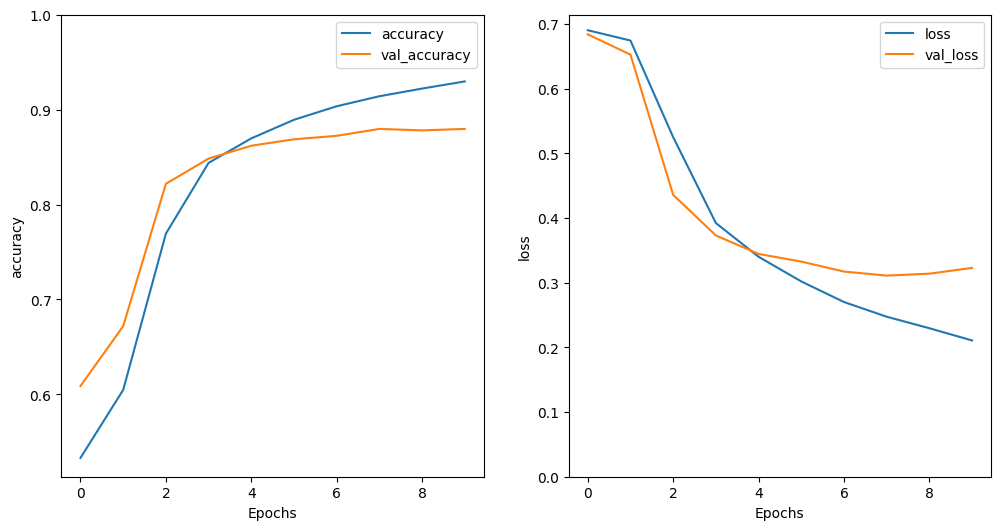

In [ ]:
# Visualizar acc y loss
plot_curvas(history)

### Método Modular - Usando arquitecturas

Recientemente, ha crecido la creación de nuevas herramientas que facilitan el uso de modelos pre-entrenados en diferentes tareas de Deep Learning. A continuación, introduccimos KerasHub una librería que ha sido propuesta para hacer uso de modelos pre-entrenado usando Keras. Esta pensanda para ser modular y esta enfocada para tareas de Clasificación de imágenes, Clasificación de texto y Tareas más especializadas sobre generación de secuencias como Audio o Texto.

**¿Qué es KerasHub?**

KerasHub es una biblioteca que proporciona modelos preentrenados para diversas tareas de aprendizaje automático. Estos modelos están implementados como capas (keras.Layer) y modelos (keras.Model) de Keras, lo que permite una integración sencilla en proyectos existentes. La biblioteca incluye modelos para clasificación de imágenes, generación de texto, clasificación de texto y más, todos accesibles a través de una API.

KerasHub organiza los modelos en componentes modulares:

**Task**: Clase de alto nivel que encapsula el modelo y el preprocesamiento para una tarea específica (por ejemplo, ImageClassifier, TextClassifier).

**Backbone**: Modelo base que extrae características de los datos de entrada.

**Preprocessor**: Capa que realiza el preprocesamiento necesario en los datos de entrada (por ejemplo, redimensionamiento de imágenes, tokenización de texto).

**Tokenizer**: Convierte texto en secuencias de tokens.

**ImageConverter**: Redimensiona y normaliza imágenes.
keras.io

Cada uno de estos componentes puede cargarse desde un preset utilizando from_preset().

![Estructura KerasHub](https://keras.io/img/guides/getting_started/class-diagram.png)



A continuación vamos a importar la arquitectura completa basada en BERT para clasificar nuestro ejercicio anterior.

**Arquitectura del modelo**: la estructura del modelo BERT.

**Pesos preentrenados**: valores aprendidos durante el entrenamiento en grandes conjuntos de datos.

**Preprocesamiento**: procesos necesarios para preparar los datos de entrada, como tokenización y normalización.

KerasHub descargará automáticamente el modelo pre-entrenado desde Hugging Face Hub.

#### Usando BERT en inferencia

BERT (Bidirectional Encoder Representations from Transformers) es un modelo de representación del lenguaje que revolucionó el procesamiento de lenguaje natural (NLP) debido a tres aportes clave:

* **Representaciones Bidireccionales Profundas**: A diferencia de modelos anteriores como GPT (unidireccional) o ELMo, BERT es completamente bidireccional, permitiendo que el modelo entienda mejor el contexto de cada palabra teniendo en cuenta tanto la izquierda como la derecha.

* **Pre-entrenamiento Universal y Fine-tuning Eficiente**: BERT puede preentrenarse en texto no etiquetado y luego afinarse con una capa de salida adicional para tareas específicas como preguntas y respuestas (QA), inferencia, y reconocimiento de entidades nombradas (NER), sin necesidad de arquitecturas especializadas para cada tarea.

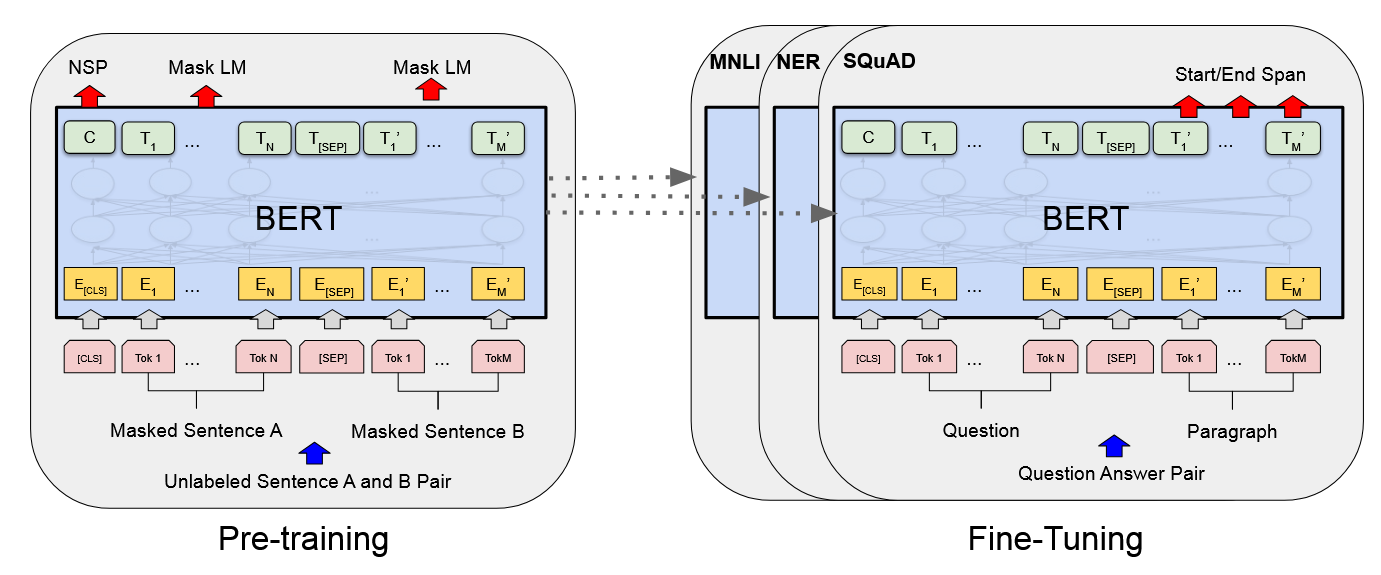

Entrenamiento en 2 fases:

1. Pre-entrenamiento (ver parte izquierda de la imagen):

  * Masked Language Model (MLM): Se ocultan aleatoriamente el 15% de los tokens para que el modelo los prediga, permitiendo el aprendizaje bidireccional.

  * Next Sentence Prediction (NSP): El modelo predice si una oración B sigue a una oración A. Esto lo entrena para tareas que implican relaciones entre frases.

2. Fine-tuning (ver parte derecha de la imagen):

  * Se adapta el modelo preentrenado a tareas específicas añadiendo una capa de salida.

  * Todos los parámetros se afinan con el conjunto de datos etiquetado de la tarea específica (e.g., QA, NER, clasificación).

In [ ]:
classifier_BERT = keras_hub.models.BertTextClassifier.from_preset(
    "bert_base_en_uncased",
    #activation='softmax', # El modelo original no la incluye
    num_classes=2,
)

100%|██████████| 510/510 [00:00<00:00, 1.29MB/s]


```
# Si se añade la función de activación softmax, las predicciones tienen la prob
# Pero no parecen estar muy convincentes, parecen estar muy neutras.

classifier_BERT.predict(test_dataset)

782/782 ━━━━━━━━━━━━━━━━━━━━ 873s 1s/step
array([[0.6197734 , 0.3802266 ],
       [0.57702965, 0.42297035],
       [0.46357015, 0.5364299 ],
       ...,
       [0.602075  , 0.39792505],
       [0.6158818 , 0.38411826],
       [0.62885654, 0.37114346]], dtype=float32)
```



In [ ]:
# Evaluar para determinar el rendimiento inicial
classifier_BERT.evaluate(test_dataset)

782/782 ━━━━━━━━━━━━━━━━━━━━ 865s 1s/step - loss: 0.9045 - sparse_categorical_accuracy: 0.4979


[0.9011728167533875, 0.49983999133110046]

Efectivamente el rendimiento no es el adecuado. Quiere decir que es génerico el resultado.

#### Y si hacemos un poco de Fine-tuning?


Si queremos hacer fine-tuning sobre más capas:
```
for layer in classifier_BERT.backbone.layers[:-4]:
    layer.trainable = False
```

Pero solo lo haremos sobre la final:

In [ ]:
# Congelamos todo el backbone y solo entrenamos la capa final
classifier_BERT.backbone.trainable = False

In [ ]:
# Re compilar con una nueva tasa de aprendizaje más pequeña
classifier_BERT.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(3e-4),
)

In [ ]:
# Entrenar con early stopping para evitar sobre entrenamiento
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=3,          # Número de épocas sin mejora después de las cuales se detendrá el entrenamiento
    verbose=1,           # Imprime un mensaje cuando el entrenamiento se detiene
    restore_best_weights=True # Restaura los pesos del modelo de la época con el mejor valor de la métrica monitoreada
)

# Ajustamos el clasificador con pocas epocas
classifier_BERT.fit(train_dataset, validation_data=test_dataset,
               epochs=15,
               callbacks=[early_stopping_callback])

Epoch 1/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 591s 1s/step - loss: 0.6668 - sparse_categorical_accuracy: 0.5892 - val_loss: 0.6053 - val_sparse_categorical_accuracy: 0.6562
Epoch 2/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 522s 1s/step - loss: 0.5861 - sparse_categorical_accuracy: 0.7168 - val_loss: 0.5421 - val_sparse_categorical_accuracy: 0.7560
Epoch 3/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 522s 1s/step - loss: 0.5484 - sparse_categorical_accuracy: 0.7403 - val_loss: 0.5594 - val_sparse_categorical_accuracy: 0.6960
Epoch 4/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 522s 1s/step - loss: 0.5295 - sparse_categorical_accuracy: 0.7512 - val_loss: 0.5033 - val_sparse_categorical_accuracy: 0.7643
Epoch 5/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 522s 1s/step - loss: 0.5126 - sparse_categorical_accuracy: 0.7631 - val_loss: 0.4770 - val_sparse_categorical_accuracy: 0.7936
Epoch 6/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 522s 1s/step - loss: 0.5102 - sparse_categorical_accuracy: 0.7595 - val_loss: 0.4724 - val_sparse_categorical_accuracy: 0.789

In [ ]:
# Finalmente evaluamos el rendimiento después de hacer fine tuning
classifier_BERT.evaluate(test_dataset)

391/391 ━━━━━━━━━━━━━━━━━━━━ 235s 600ms/step - loss: 0.4238 - sparse_categorical_accuracy: 0.8131


[0.4228881299495697, 0.8147199749946594]

#### Usando tú propio BERT

Tendrás que hacer los siguientes pasos:

1. Configurar el tokenizador con el vocabulario que hayas definido (como lo hicimos en el ejemplo base.
2. Crear un preprocesador
3. Definir el backbone, con las dimensiones deseadas (*ya sabes de que hablamos si conoces Transformers*),
4. Construir el clasificador y entrenar en tus datos)

```
tokenizer = keras_hub.models.BertTokenizer(
    vocabulary=vocab,

preprocessor = keras_hub.models.BertTextClassifierPreprocessor(
    tokenizer=tokenizer,
    sequence_length=128,
)
backbone = keras_hub.models.BertBackbone(
    vocabulary_size=30552,
    num_layers=4,
    num_heads=4,
    hidden_dim=256,
    intermediate_dim=512,
    max_sequence_length=128,
)
classifier = keras_hub.models.BertTextClassifier(
    backbone=backbone,
    preprocessor=preprocessor,
    num_classes=4,
)
classifier.fit(x=features, y=labels, batch_size=2)
```

Para más información consultar: [Getting Started con Keras Hub](https://keras.io/keras_hub/getting_started/)

Además puede consultar todos los modelos pre-entrenados en [Keras presets](https://keras.io/keras_hub/presets/) y las arquitecturas disponibles [Keras architectures](https://keras.io/keras_hub/api/models/)

Para más sobre [BERT](https://github.com/google-research/bert).

## Pre-training en Datos tabulares usando TabNet y TabPNF

🎯 **Objetivos del ejercicio**

1. Aplicar pre-entrenamiento en un dataset de phishing real.

2. Comparar dos formas distintas de aprendizaje transferido:

  * Fine-tuning supervisado con TabNet.

  * Inferencia con modelo fundacional TabPFN (sin ajuste).

3. Analizar ventajas y desventajas de cada enfoque en un escenario real.

In [11]:
# leer datos
df1, _ = leer_datos_phishing()

In [12]:
df1

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,1,1,-1,0
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,-1,-1,0,-1,1,1,1,0
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,-1,1,-1,1,0,-1,0
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,1,-1,1,-1,1,0
4,1,0,-1,1,1,-1,1,1,-1,1,...,-1,1,-1,-1,0,-1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11050,1,-1,1,-1,1,1,1,1,-1,-1,...,-1,-1,1,1,-1,-1,1,1,1,1
11051,-1,1,1,-1,-1,-1,1,-1,-1,-1,...,-1,1,1,1,1,1,1,-1,1,0
11052,1,-1,1,1,1,-1,1,-1,-1,1,...,1,1,1,1,1,-1,1,0,1,0
11053,-1,-1,1,1,1,-1,-1,-1,1,-1,...,-1,1,1,1,1,-1,1,1,1,0


In [14]:
# crear conjuntos de features y labels
y = df1['Result']
X = df1.drop(columns=['Result'])

In [50]:
# crear conjuntos de pretrain, train y test
X_pretrain, X_remaining, y_pretrain, y_remaining = train_test_split(
    X, y, test_size=0.9, random_state=42, stratify=y
)

X_train, X_test, y_train, y_test = train_test_split(
    X_remaining, y_remaining, test_size=0.3, random_state=42,
)

X_pretrain.shape, X_train.shape, X_test.shape

((1105, 30), (6965, 30), (2985, 30))

#### ¿Cómo hace fine-tuning TabPFN?

TabPFN **no necesita fine-tuning tradicional**. Ya está **preentrenado** con millones de tareas sintéticas, por lo que funciona como un modelo fundacional para datos tabulares.

En lugar de entrenarse, TabPFN realiza **"in-context learning"**: usa un pequeño conjunto de ejemplos como contexto y generaliza a nuevos datos sin modificar sus pesos.

### 📌 Diferencias clave

- ❌ No entrena pesos → ✅ Usa ejemplos como contexto
- ❌ No necesita optimizador → ✅ Solo llamas `.fit()` una vez
- ✅ Listo para usar en tareas nuevas con pocos datos

> Es una forma moderna de **transfer learning sin reentrenamiento**, parecida a cómo funcionan los modelos como GPT.


In [52]:
tabpfn = TabPFNClassifier(device="cuda" if torch.cuda.is_available() else "cpu")

# No necesita entrenamiento, solo predicción directa
tabpfn.fit(X_pretrain, y_pretrain)  # Simula el preentrenamiento en otro dominio

preds_pfn = tabpfn.predict(X_test)
probs_pfn = tabpfn.predict_proba(X_test)

print("TabPFN Accuracy:", accuracy_score(y_test, preds_pfn))
print("TabPFN ROC AUC:", roc_auc_score(y_test, probs_pfn[:,1]))

TabPFN Accuracy: 0.9363484087102177
TabPFN ROC AUC: 0.9870633157443613


#### ¿Cómo se hace preentrenamiento en TabNet?

TabNet permite aplicar **transfer learning tradicional** con datos tabulares, utilizando un enfoque en dos fases:

#### 🔄 1. Preentrenamiento no supervisado

Se entrena el modelo como un **autoencoder**:
- Aprende a reconstruir los datos de entrada
- Captura patrones estructurales y relaciones entre atributos
- No necesita etiquetas (`unsupervised pretraining`)

Esto le permite aprender una buena representación de los datos, útil para tareas futuras.

#### 🏷️ 2. Fine-tuning supervisado

Luego se reutilizan los pesos aprendidos para entrenar el modelo en una tarea específica:
- Se conecta una capa de clasificación
- Se ajustan los pesos con ejemplos etiquetados
- Mejora la generalización, especialmente si hay pocos datos etiquetados

> TabNet sigue una estrategia clásica de **transfer learning por ajuste fino**, similar a la usada en visión por CNNs: preentrenar primero, y luego adaptar.


#### Parámetros de TabNet (Instanciar)

| Parámetro                              | Descripción                                                                                     |
| -------------------------------------- | ----------------------------------------------------------------------------------------------- |
| `n_d` / `n_a`                          | Dimensión de la capa de decisión y atención. Usualmente entre 8 y 64. Recomendado: `n_d = n_a`. |
| `n_steps`                              | Número de pasos (bloques de atención). Sugerido: 3–10.                                          |
| `gamma`                                | Coeficiente de reuso de características en las máscaras. Rango: 1.0–2.0 (default 1.3).          |
| `cat_idxs`                             | Índices de las variables categóricas (requerido para embeddings).                               |
| `cat_dims`                             | Número de categorías únicas por variable categórica.                                            |
| `cat_emb_dim`                          | Dimensiones de embedding por variable categórica. Default: 1.                                   |
| `n_shared` / `n_independent`           | Capas GLU compartidas e independientes por paso. Usual: 1–5.                                    |
| `epsilon`                              | Estabilidad numérica. No modificar (default `1e-15`).                                           |
| `seed`                                 | Semilla para reproducibilidad.                                                                  |
| `momentum`                             | Momentum para batch norm. Rango típico: 0.01–0.4. Default: 0.02.                                |
| `clip_value`                           | Valor para *gradient clipping*. Default: `None`.                                                |
| `lambda_sparse`                        | Coeficiente para pérdida de dispersión. Mayor → más enmascaramiento. Default: `1e-3`.           |
| `optimizer_fn`                         | Optimizador de PyTorch. Default: `torch.optim.Adam`.                                            |
| `optimizer_params`                     | Parámetros del optimizador. Default: `{'lr': 2e-2}`.                                            |
| `scheduler_fn` / `scheduler_params`    | Scheduler de tasa de aprendizaje y sus parámetros. Ej: `{"gamma": 0.95, "step_size": 10}`.      |
| `model_name`                           | Nombre del modelo para guardar. Default: `"DreamQuarkTabNet"`.                                  |
| `verbose`                              | Nivel de verbosidad. `0` (silencio) o `1` (mostrar épocas).                                     |
| `device_name`                          | `"cpu"`, `"cuda"` o `"auto"`.                                                                    |
| `mask_type`                            | Tipo de máscara: `"sparsemax"` o `"entmax"`.                                                    |
| `grouped_features`                     | Agrupación de variables correlacionadas (ej. PCA o TF-IDF).                                     |
| `n_shared_decoder` / `n_indep_decoder` | Solo para preentrenamiento. Bloques GLU compartidos/independientes en decoder.                  |


#### Parámetros de entrenamiento (fit)

| Parámetro            | Descripción                                                                                          |
| -------------------- | ---------------------------------------------------------------------------------------------------- |
| `X_train`, `y_train` | Datos y etiquetas de entrenamiento.                                                                  |
| `eval_set`           | Lista de tuplas (X, y) para evaluación. La última se usa para *early stopping*.                      |
| `eval_name`          | Nombres para los conjuntos de evaluación.                                                            |
| `eval_metric`        | Lista de métricas (ej. `"accuracy"`, `"auc"`, `"rmse"`). La última se usa para *early stopping*.     |
| `max_epochs`         | Número máximo de épocas. Default: 200.                                                               |
| `patience`           | Épocas sin mejora antes de detener. Default: 10.                                                     |
| `weights`            | Solo para clasificación. `0`: sin ponderación, `1`: ponderación automática, `dict`: pesos por clase. |
| `loss_fn`            | Función de pérdida. Default: `mse` (regresión) o `cross_entropy` (clasificación).                    |
| `batch_size`         | Tamaño del batch. Sugerido: grande (ej. 1024).                                                       |
| `virtual_batch_size` | Para *Ghost Batch Norm*. Debe dividir `batch_size`. Default: 128.                                    |
| `num_workers`        | Número de workers para `DataLoader`.                                                                 |
| `drop_last`          | Si se debe descartar el último batch incompleto.                                                     |
| `callbacks`          | Lista de *callbacks* personalizados.                                                                 |
| `pretraining_ratio`  | Solo `TabNetPretrainer`: proporción de características a enmascarar (entre 0 y 1).                   |
| `warm_start`         | Permite continuar entrenamiento previo.                                                              |
| `compute_importance` | Si se deben calcular importancias de variables. Default: `True`.                                     |


In [53]:
# Primero revisar el rendimiento normal
clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    scheduler_params={"step_size":10, "gamma":0.9},
    mask_type='entmax', #sparsemax
    device_name='cuda'
)

# entrenar en los datos de train
clf.fit(
    X_train=X_train.values, y_train=y_train.values,
    eval_set=[(X_test.values, y_test.values)],
    eval_name=['test'],
    eval_metric=['accuracy'],
    max_epochs=50,
    num_workers=2
)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.68499 | test_accuracy: 0.67806 |  0:00:00s
epoch 1  | loss: 0.5307  | test_accuracy: 0.77688 |  0:00:01s
epoch 2  | loss: 0.40529 | test_accuracy: 0.83082 |  0:00:01s
epoch 3  | loss: 0.31463 | test_accuracy: 0.87035 |  0:00:02s
epoch 4  | loss: 0.25766 | test_accuracy: 0.88409 |  0:00:03s
epoch 5  | loss: 0.21586 | test_accuracy: 0.88677 |  0:00:03s
epoch 6  | loss: 0.2069  | test_accuracy: 0.89916 |  0:00:04s
epoch 7  | loss: 0.20151 | test_accuracy: 0.90184 |  0:00:04s
epoch 8  | loss: 0.18626 | test_accuracy: 0.90218 |  0:00:05s
epoch 9  | loss: 0.17794 | test_accuracy: 0.90921 |  0:00:06s
epoch 10 | loss: 0.17627 | test_accuracy: 0.9139  |  0:00:06s
epoch 11 | loss: 0.16566 | test_accuracy: 0.91725 |  0:00:07s
epoch 12 | loss: 0.15886 | test_accuracy: 0.91826 |  0:00:07s
epoch 13 | loss: 0.15659 | test_accuracy: 0.92261 |  0:00:08s
epoch 14 | loss: 0.15288 | test_accuracy: 0.92261 |  0:00:09s
epoch 15 | loss: 0.14653 | test_accuracy: 0.9263  |  0:00:09s
epoch 16

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [54]:
# Calcular rendimiento en test set
preds_tabnet = clf.predict(X_test.values)
probs_tabnet = clf.predict_proba(X_test.values)

print("TabNet Accuracy:", accuracy_score(preds_tabnet, y_test.values))
print("TabNet ROC AUC:", roc_auc_score(y_test.values, probs_tabnet[:,1]))

TabNet Accuracy: 0.9484087102177554
TabNet ROC AUC: 0.98806641544769


Ahora aplicamos el entrenamiento sin supervisación para usarlo en una nueva fase de entrenamiento.

In [56]:
# Hacer el pre-entrenamiento
unsupervised_model = TabNetPretrainer(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax' # "sparsemax"
)

unsupervised_model.fit(
    X_train=X_pretrain.values,
    eval_set=[X_test.values],
    pretraining_ratio=0.7,
    max_epochs=50 , patience=10,
)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 7.70281 | val_0_unsup_loss_numpy: 3.1214799880981445|  0:00:00s
epoch 1  | loss: 5.7328  | val_0_unsup_loss_numpy: 2.701740026473999|  0:00:00s
epoch 2  | loss: 4.4344  | val_0_unsup_loss_numpy: 2.511159896850586|  0:00:00s
epoch 3  | loss: 3.81245 | val_0_unsup_loss_numpy: 2.3322200775146484|  0:00:00s
epoch 4  | loss: 3.29634 | val_0_unsup_loss_numpy: 2.1348400115966797|  0:00:00s
epoch 5  | loss: 2.85611 | val_0_unsup_loss_numpy: 2.057849884033203|  0:00:01s
epoch 6  | loss: 2.71231 | val_0_unsup_loss_numpy: 1.9059200286865234|  0:00:01s
epoch 7  | loss: 2.38177 | val_0_unsup_loss_numpy: 1.8024100065231323|  0:00:01s
epoch 8  | loss: 2.18751 | val_0_unsup_loss_numpy: 1.6448800563812256|  0:00:01s
epoch 9  | loss: 2.02259 | val_0_unsup_loss_numpy: 1.567080020904541|  0:00:01s
epoch 10 | loss: 1.86974 | val_0_unsup_loss_numpy: 1.5137499570846558|  0:00:01s
epoch 11 | loss: 1.77057 | val_0_unsup_loss_numpy: 1.4762799739837646|  0:00:02s
epoch 12 | loss: 1.6627  | val_0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Realizamos nuevamente el entrenamiento pero esta vez con la información del pre-entrenamiento y un poco más de iteraciones con una lr más pequeña.

In [58]:
clf_pre = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=5e-2),
    scheduler_params={"step_size":10,
                      "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    device_name='cuda',
)

clf_pre.fit(
    X_train=X_train.values, y_train=y_train.values,
    eval_set=[(X_test.values, y_test.values)],
    eval_name=['valid'],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=10,
    num_workers=2,
    from_unsupervised=unsupervised_model
)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:118: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.58518 | valid_accuracy: 0.73501 |  0:00:00s
epoch 1  | loss: 0.3542  | valid_accuracy: 0.8134  |  0:00:01s
epoch 2  | loss: 0.25695 | valid_accuracy: 0.82948 |  0:00:01s
epoch 3  | loss: 0.21335 | valid_accuracy: 0.84556 |  0:00:02s
epoch 4  | loss: 0.19294 | valid_accuracy: 0.88744 |  0:00:03s
epoch 5  | loss: 0.17544 | valid_accuracy: 0.90854 |  0:00:03s
epoch 6  | loss: 0.16518 | valid_accuracy: 0.90955 |  0:00:04s
epoch 7  | loss: 0.16018 | valid_accuracy: 0.92663 |  0:00:04s
epoch 8  | loss: 0.16061 | valid_accuracy: 0.92898 |  0:00:05s
epoch 9  | loss: 0.14704 | valid_accuracy: 0.9273  |  0:00:06s
epoch 10 | loss: 0.15013 | valid_accuracy: 0.93065 |  0:00:06s
epoch 11 | loss: 0.14978 | valid_accuracy: 0.934   |  0:00:07s
epoch 12 | loss: 0.13681 | valid_accuracy: 0.93601 |  0:00:07s
epoch 13 | loss: 0.13114 | valid_accuracy: 0.93869 |  0:00:08s
epoch 14 | loss: 0.12579 | valid_accuracy: 0.93534 |  0:00:09s
epoch 15 | loss: 0.11833 | valid_accuracy: 0.93936 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [59]:
# Calcular rendimiento en test set
preds_tabnet = clf_pre.predict(X_test.values)
probs_tabnet = clf_pre.predict_proba(X_test.values)

print("TabNet Accuracy:", accuracy_score(preds_tabnet, y_test.values))
print("TabNet ROC AUC:", roc_auc_score(y_test.values, probs_tabnet[:,1]))

TabNet Accuracy: 0.9644891122278056
TabNet ROC AUC: 0.9922004159049486


#### Comparación de resultados: TabPFN vs TabNet

Todos los modelos fueron evaluados sobre el mismo conjunto de prueba (`X_test`). A continuación se resumen sus resultados:

| Modelo                         | Entrenamiento               | Accuracy  | ROC AUC   |
|-------------------------------|-----------------------------|-----------|-----------|
| **TabPFN**                    | Solo conjunto pretrain | **0.9363**  | **0.9871**  |
| **TabNet (sin preentrenamiento)** | Entrenamiento completo          | 0.9484    | 0.9881    |
| **TabNet (con preentrenamiento)** | Pretrain + fine-tuning          | **0.9645**  | **0.9922**  |

### 🧠 Observaciones clave:

- 🔹 **TabPFN**, aún usando un conjunto más pequeño de entrenamiento, alcanza una **precisión y AUC muy competitiva**, gracias a su preentrenamiento fundacional.  
- 🔹 **TabNet mejora** al usar preentrenamiento no supervisado, mostrando un claro beneficio del transfer learning clásico.  
- ✅ Estos resultados ilustran **dos formas diferentes de aprovechar el conocimiento previo**:  
  - TabPFN: transferencia por meta-aprendizaje (in-context learning)  
  - TabNet: transferencia por preentrenamiento + fine-tuning  


## **Conclusiones**

- Note que al agregarle al modelo mas capas superiores, logramos mitigar el problema que presentamos en nuestro modelo 2, logrando un *accuracy* del 99.30% en nuestro datos de prueba.
- Como conlusión, cuando hagamos uso de modelo pre-entrenados. Tenemos que hacer uso de todas las herramientas que disponemos, como lo son el *transfer learning* y el *fine tunning*, una caracteristica muy importante que siempre hay que aplicar.
- En el modelo de clasificación de texto usando el método manual, logró una mejora significativa usando los embeddings de FastText y ajustandolo a los datos. Sin embargo, tiende a sobre entrenar (algo con lo que se debe luchar aplicando técnicas de regularización). Por otro lado, vemos que con el método a nivel de arquitectura (que es como funcionan los modelos hoy en día) ya es mucho más directo pero el nivel de computación requerido es mayor y funcionan mejor con una mayor cantidad de datos.
- Tanto TabPFN como TabNet demuestran el valor del transfer learning en datos tabulares.  
TabPFN destaca por su capacidad de generalizar con muy pocos datos gracias a su preentrenamiento fundacional,  
mientras que TabNet muestra mejoras claras cuando se utiliza preentrenamiento no supervisado antes del fine-tuning